# Energy Consumption Prediction Project

## Project Overview
This project aims to predict energy consumption based on various building characteristics including:
- Building Type (Residential, Commercial, Industrial)
- Square Footage
- Number of Occupants
- Appliances Used
- Average Temperature
- Day of Week (Weekday/Weekend)

We'll explore the data, build multiple machine learning models, and evaluate their performance to find the best predictor for energy consumption.


In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Cell 2: Load and explore the datasets
# Load training data
train_data = pd.read_csv('train_energy_data.csv')

# Load testing data  
test_data = pd.read_csv('test_energy_data.csv')

print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)
print("\nFirst 5 rows of training data:")
print(train_data.head())


Training Data Shape: (1000, 7)
Testing Data Shape: (100, 7)

First 5 rows of training data:
  Building Type  Square Footage  Number of Occupants  Appliances Used  \
0   Residential            7063                   76               10   
1    Commercial           44372                   66               45   
2    Industrial           19255                   37               17   
3   Residential           13265                   14               41   
4    Commercial           13375                   26               18   

   Average Temperature Day of Week  Energy Consumption  
0                29.84     Weekday             2713.95  
1                16.72     Weekday             5744.99  
2                14.30     Weekend             4101.24  
3                32.82     Weekday             3009.14  
4                11.92     Weekday             3279.17  


## Data Cleaning and Preprocessing

Let's clean the data and prepare it for machine learning models. We'll handle any missing values, encode categorical variables, and ensure data quality.


In [3]:
# Cell 4: Data cleaning function
def clean_data(df):
    """
    Clean and preprocess the energy consumption dataset
    """
    # Create a copy to avoid modifying original data
    df_clean = df.copy()
    
    # Check for and handle missing values
    if df_clean.isnull().sum().sum() > 0:
        print("Handling missing values...")
        # Fill numerical columns with median
        numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if df_clean[col].isnull().sum() > 0:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
        
        # Fill categorical columns with mode
        categorical_cols = df_clean.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df_clean[col].isnull().sum() > 0:
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # Remove any potential duplicates
    df_clean = df_clean.drop_duplicates()
    
    # Check for outliers using IQR method for numerical columns
    numerical_cols = ['Square Footage', 'Number of Occupants', 'Appliances Used', 
                     'Average Temperature', 'Energy Consumption']
    
    for col in numerical_cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count outliers
            outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
            if len(outliers) > 0:
                print(f"Found {len(outliers)} outliers in {col}")
    
    return df_clean

# Clean both datasets
train_clean = clean_data(train_data)
test_clean = clean_data(test_data)

print("Data cleaning completed!")
print(f"Training data shape after cleaning: {train_clean.shape}")
print(f"Testing data shape after cleaning: {test_clean.shape}")


Data cleaning completed!
Training data shape after cleaning: (1000, 7)
Testing data shape after cleaning: (100, 7)


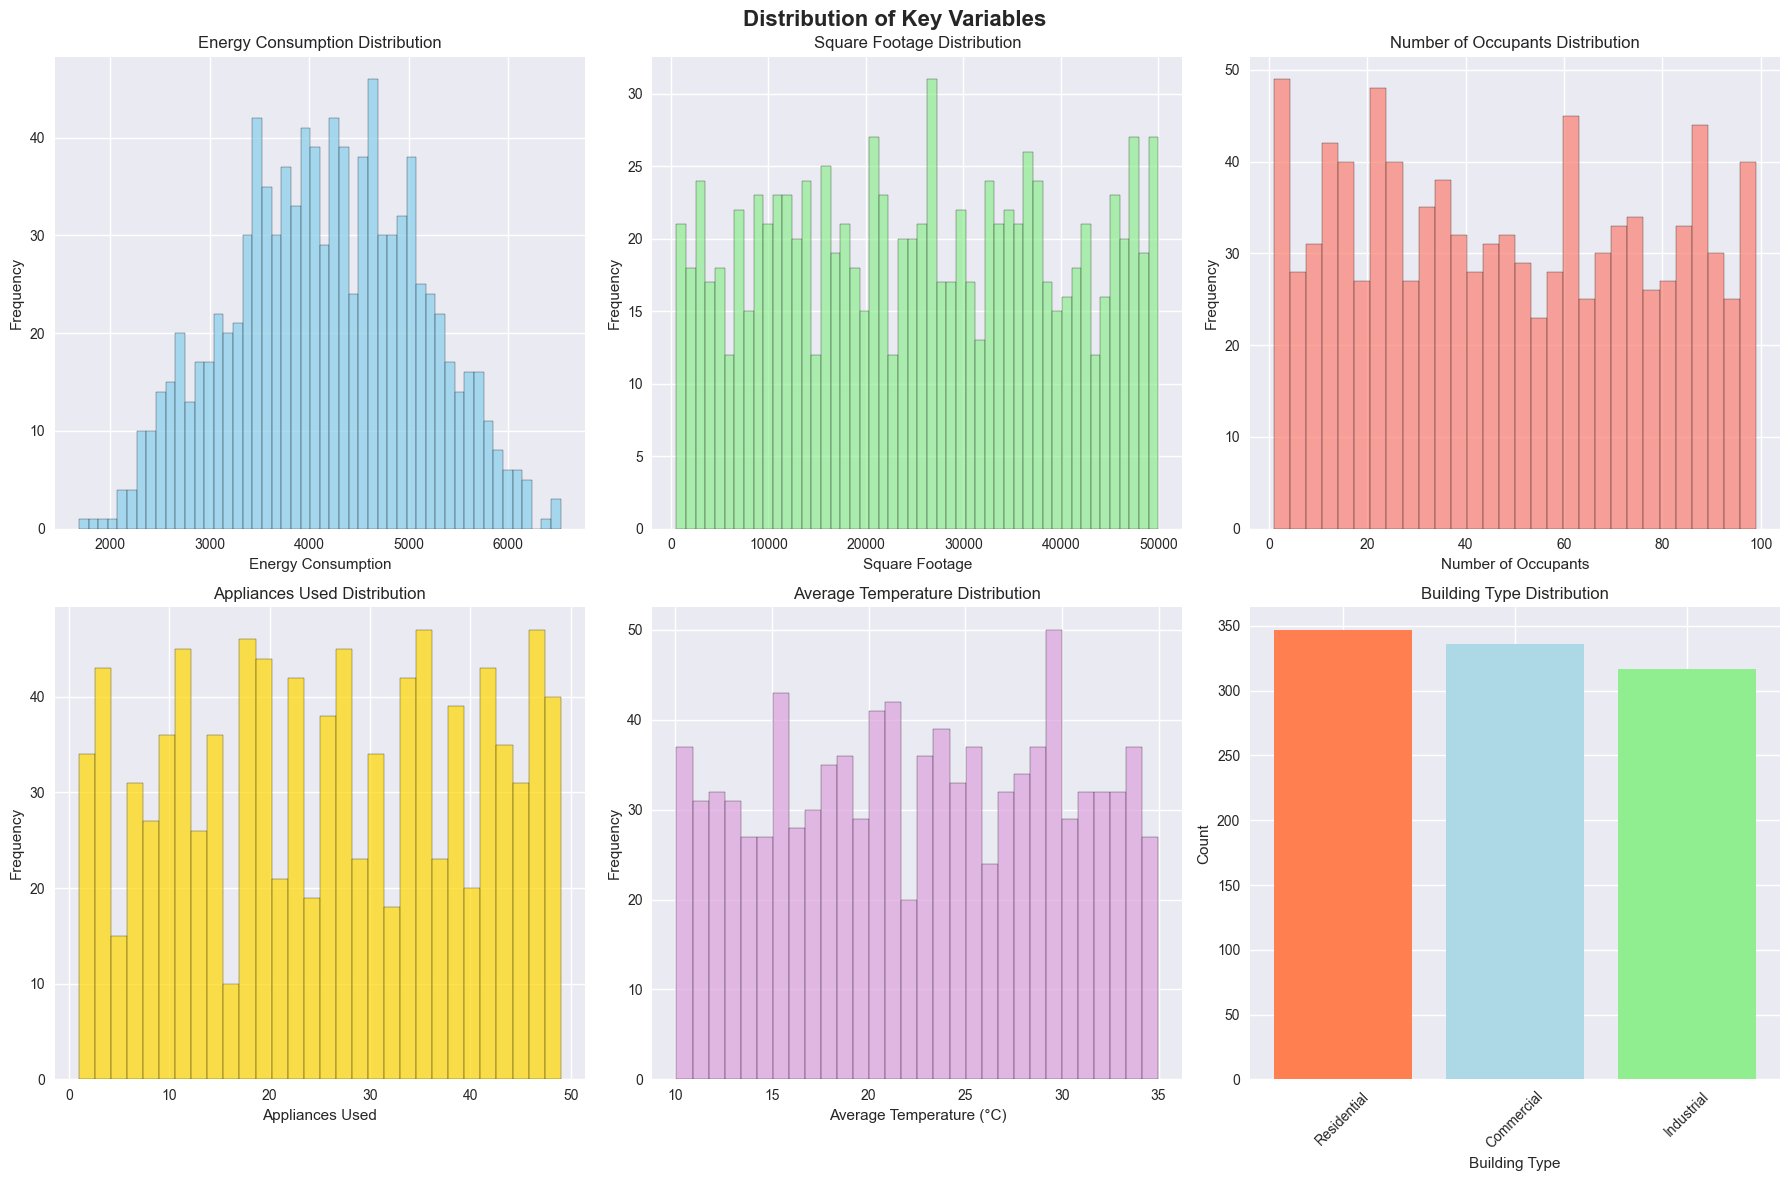

In [4]:
# Cell 5: Exploratory Data Analysis - Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Key Variables', fontsize=16, fontweight='bold')

# Energy Consumption distribution
axes[0, 0].hist(train_clean['Energy Consumption'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Energy Consumption Distribution')
axes[0, 0].set_xlabel('Energy Consumption')
axes[0, 0].set_ylabel('Frequency')

# Square Footage distribution
axes[0, 1].hist(train_clean['Square Footage'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Square Footage Distribution')
axes[0, 1].set_xlabel('Square Footage')
axes[0, 1].set_ylabel('Frequency')

# Number of Occupants distribution
axes[0, 2].hist(train_clean['Number of Occupants'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
axes[0, 2].set_title('Number of Occupants Distribution')
axes[0, 2].set_xlabel('Number of Occupants')
axes[0, 2].set_ylabel('Frequency')

# Appliances Used distribution
axes[1, 0].hist(train_clean['Appliances Used'], bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[1, 0].set_title('Appliances Used Distribution')
axes[1, 0].set_xlabel('Appliances Used')
axes[1, 0].set_ylabel('Frequency')

# Average Temperature distribution
axes[1, 1].hist(train_clean['Average Temperature'], bins=30, alpha=0.7, color='plum', edgecolor='black')
axes[1, 1].set_title('Average Temperature Distribution')
axes[1, 1].set_xlabel('Average Temperature (°C)')
axes[1, 1].set_ylabel('Frequency')

# Building Type distribution
building_counts = train_clean['Building Type'].value_counts()
axes[1, 2].bar(building_counts.index, building_counts.values, color=['coral', 'lightblue', 'lightgreen'])
axes[1, 2].set_title('Building Type Distribution')
axes[1, 2].set_xlabel('Building Type')
axes[1, 2].set_ylabel('Count')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


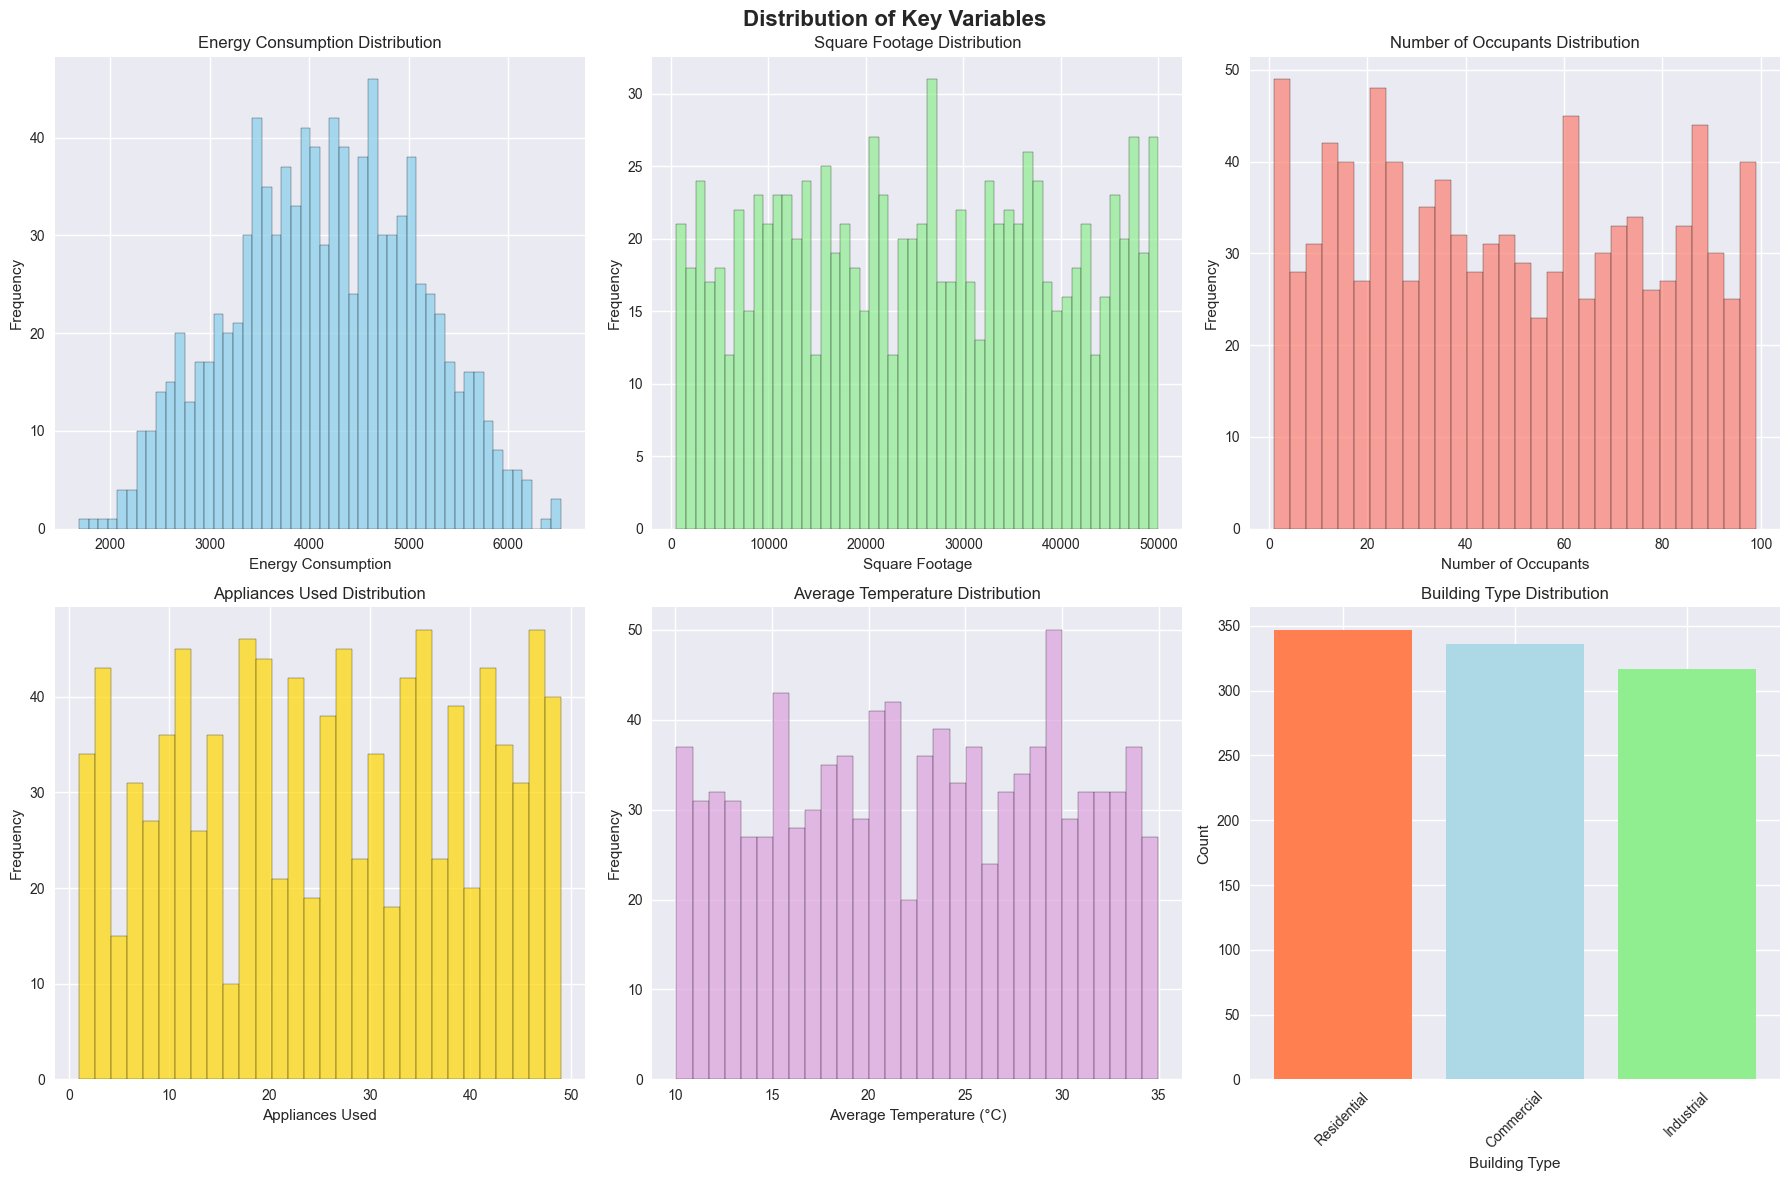

In [5]:
# Cell 5: Exploratory Data Analysis - Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Key Variables', fontsize=16, fontweight='bold')

# Energy Consumption distribution
axes[0, 0].hist(train_clean['Energy Consumption'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Energy Consumption Distribution')
axes[0, 0].set_xlabel('Energy Consumption')
axes[0, 0].set_ylabel('Frequency')

# Square Footage distribution
axes[0, 1].hist(train_clean['Square Footage'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Square Footage Distribution')
axes[0, 1].set_xlabel('Square Footage')
axes[0, 1].set_ylabel('Frequency')

# Number of Occupants distribution
axes[0, 2].hist(train_clean['Number of Occupants'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
axes[0, 2].set_title('Number of Occupants Distribution')
axes[0, 2].set_xlabel('Number of Occupants')
axes[0, 2].set_ylabel('Frequency')

# Appliances Used distribution
axes[1, 0].hist(train_clean['Appliances Used'], bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[1, 0].set_title('Appliances Used Distribution')
axes[1, 0].set_xlabel('Appliances Used')
axes[1, 0].set_ylabel('Frequency')

# Average Temperature distribution
axes[1, 1].hist(train_clean['Average Temperature'], bins=30, alpha=0.7, color='plum', edgecolor='black')
axes[1, 1].set_title('Average Temperature Distribution')
axes[1, 1].set_xlabel('Average Temperature (°C)')
axes[1, 1].set_ylabel('Frequency')

# Building Type distribution
building_counts = train_clean['Building Type'].value_counts()
axes[1, 2].bar(building_counts.index, building_counts.values, color=['coral', 'lightblue', 'lightgreen'])
axes[1, 2].set_title('Building Type Distribution')
axes[1, 2].set_xlabel('Building Type')
axes[1, 2].set_ylabel('Count')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


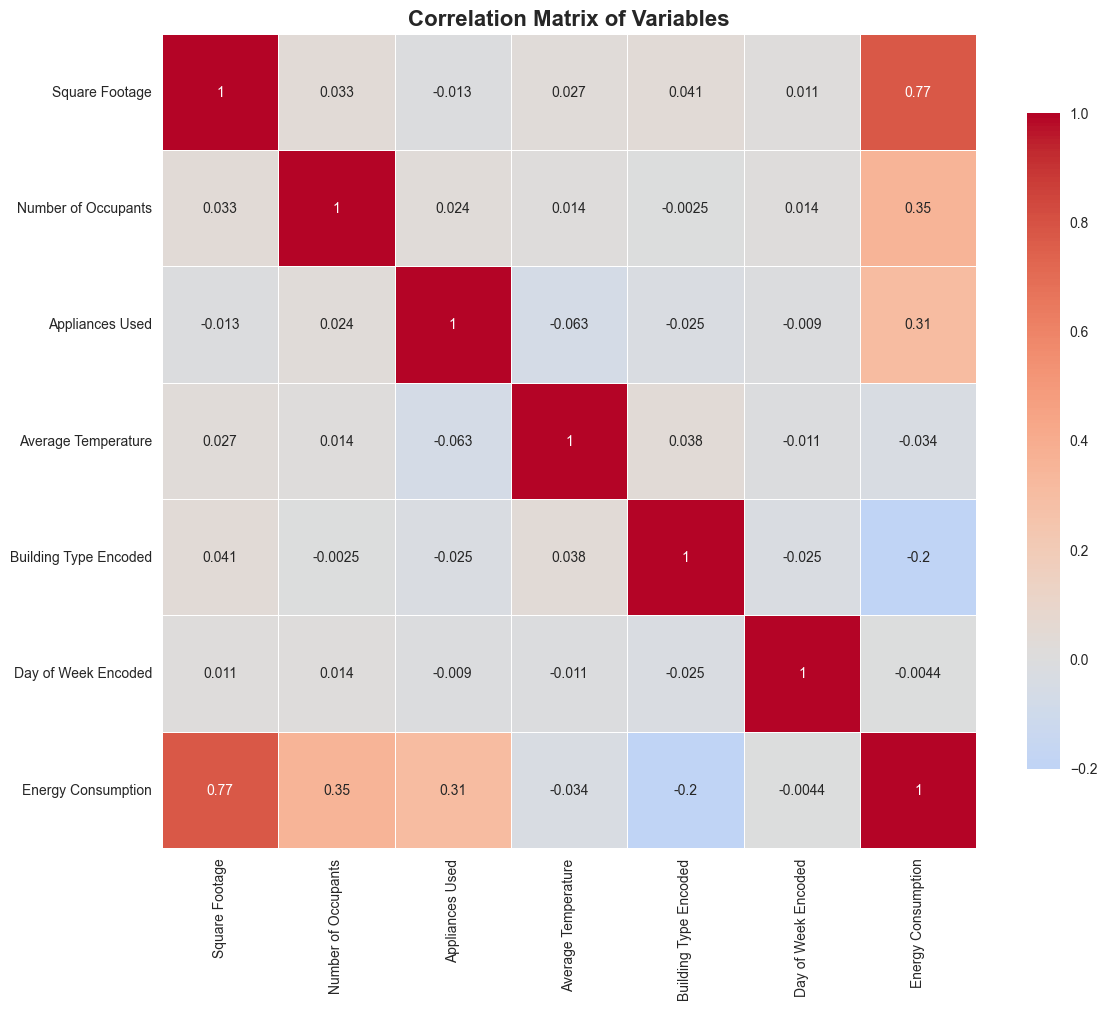

Correlation with Energy Consumption:
Square Footage: 0.775
Number of Occupants: 0.354
Appliances Used: 0.313
Building Type Encoded: -0.202
Average Temperature: -0.034
Day of Week Encoded: -0.004


In [6]:
# Cell 6: Correlation analysis and heatmap
# Prepare data for correlation analysis
train_corr = train_clean.copy()

# Encode categorical variables for correlation analysis
le_building = LabelEncoder()
le_day = LabelEncoder()

train_corr['Building Type Encoded'] = le_building.fit_transform(train_corr['Building Type'])
train_corr['Day of Week Encoded'] = le_day.fit_transform(train_corr['Day of Week'])

# Select numerical columns for correlation
numerical_cols = ['Square Footage', 'Number of Occupants', 'Appliances Used', 
                 'Average Temperature', 'Building Type Encoded', 'Day of Week Encoded', 
                 'Energy Consumption']

correlation_matrix = train_corr[numerical_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print correlation with target variable
print("Correlation with Energy Consumption:")
target_corr = correlation_matrix['Energy Consumption'].sort_values(key=abs, ascending=False)
for var, corr in target_corr.items():
    if var != 'Energy Consumption':
        print(f"{var}: {corr:.3f}")


## Feature Engineering and Data Preparation

Now we'll prepare the data for machine learning by encoding categorical variables and scaling features.


In [7]:
# Cell 8: Feature engineering and preprocessing
def prepare_features(df, le_building=None, le_day=None, scaler=None, fit_transform=True):
    """
    Prepare features for machine learning models
    """
    df_processed = df.copy()
    
    # Initialize encoders and scaler if not provided
    if le_building is None:
        le_building = LabelEncoder()
    if le_day is None:
        le_day = LabelEncoder()
    if scaler is None:
        scaler = StandardScaler()
    
    # Encode categorical variables
    if fit_transform:
        df_processed['Building Type Encoded'] = le_building.fit_transform(df_processed['Building Type'])
        df_processed['Day of Week Encoded'] = le_day.fit_transform(df_processed['Day of Week'])
    else:
        df_processed['Building Type Encoded'] = le_building.transform(df_processed['Building Type'])
        df_processed['Day of Week Encoded'] = le_day.transform(df_processed['Day of Week'])
    
    # Create additional features
    df_processed['Occupancy_Density'] = df_processed['Number of Occupants'] / df_processed['Square Footage']
    df_processed['Appliances_per_Occupant'] = df_processed['Appliances Used'] / (df_processed['Number of Occupants'] + 1)
    df_processed['Size_Category'] = pd.cut(df_processed['Square Footage'], 
                                          bins=[0, 15000, 30000, 50000], 
                                          labels=['Small', 'Medium', 'Large'])
    df_processed['Size_Category_Encoded'] = LabelEncoder().fit_transform(df_processed['Size_Category'].astype(str))
    
    # Select features for modeling
    feature_columns = ['Square Footage', 'Number of Occupants', 'Appliances Used', 
                      'Average Temperature', 'Building Type Encoded', 'Day of Week Encoded',
                      'Occupancy_Density', 'Appliances_per_Occupant', 'Size_Category_Encoded']
    
    X = df_processed[feature_columns]
    
    # Scale features
    if fit_transform:
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)
    
    return X_scaled, le_building, le_day, scaler

# Prepare training features
X_train, le_building, le_day, scaler = prepare_features(train_clean, fit_transform=True)
y_train = train_clean['Energy Consumption']

# Prepare test features
X_test, _, _, _ = prepare_features(test_clean, le_building, le_day, scaler, fit_transform=False)
y_test = test_clean['Energy Consumption']

print("Feature preparation completed!")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Feature columns: {list(X_train.columns)}")


Feature preparation completed!
Training features shape: (1000, 9)
Test features shape: (100, 9)
Feature columns: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Building Type Encoded', 'Day of Week Encoded', 'Occupancy_Density', 'Appliances_per_Occupant', 'Size_Category_Encoded']


## Model Development and Comparison

We'll train multiple machine learning models and compare their performance to find the best one for energy consumption prediction.


In [8]:
# Cell 9: Define and train multiple models
def train_models(X_train, y_train):
    """
    Train multiple regression models and return them with their performance
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    trained_models = {}
    model_scores = {}
    
    print("Training models...")
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        model_scores[name] = {
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std()
        }
        
        print(f"{name} - CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return trained_models, model_scores

# Train all models
trained_models, model_scores = train_models(X_train, y_train)


Training models...
Training Linear Regression...
Linear Regression - CV R² Score: 0.8566 (+/- 0.0221)
Training Decision Tree...
Decision Tree - CV R² Score: 0.9262 (+/- 0.0160)
Training Random Forest...
Random Forest - CV R² Score: 0.9765 (+/- 0.0062)
Training Gradient Boosting...
Gradient Boosting - CV R² Score: 0.9904 (+/- 0.0032)


In [9]:
# Cell 10: Hyperparameter tuning for the best performing models
def tune_random_forest(X_train, y_train):
    """
    Tune Random Forest hyperparameters
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_, grid_search.best_params_

def tune_gradient_boosting(X_train, y_train):
    """
    Tune Gradient Boosting hyperparameters
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    
    gb = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(gb, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_, grid_search.best_params_

# Tune the top performing models
print("Tuning Random Forest...")
best_rf, best_rf_params = tune_random_forest(X_train, y_train)
print(f"Best RF parameters: {best_rf_params}")

print("\nTuning Gradient Boosting...")
best_gb, best_gb_params = tune_gradient_boosting(X_train, y_train)
print(f"Best GB parameters: {best_gb_params}")

# Add tuned models to our collection
trained_models['Random Forest (Tuned)'] = best_rf
trained_models['Gradient Boosting (Tuned)'] = best_gb


Tuning Random Forest...
Best RF parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Tuning Gradient Boosting...
Best GB parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


## Model Evaluation and Testing

Let's evaluate all models on the test set and determine the best performing model.


In [10]:
# Cell 11: Comprehensive model evaluation
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a model and return comprehensive metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Predictions': y_pred
    }

# Evaluate all models
evaluation_results = []
predictions_dict = {}

print("Evaluating models on test set...")
print("="*60)

for name, model in trained_models.items():
    results = evaluate_model(model, X_test, y_test, name)
    evaluation_results.append(results)
    predictions_dict[name] = results['Predictions']
    
    print(f"{name}:")
    print(f"  RMSE: {results['RMSE']:.2f}")
    print(f"  MAE:  {results['MAE']:.2f}")
    print(f"  R²:   {results['R²']:.4f}")
    print(f"  MAPE: {results['MAPE']:.2f}%")
    print("-" * 40)

# Create results DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.drop('Predictions', axis=1)
results_df = results_df.sort_values('R²', ascending=False)

print("\nModel Performance Summary (sorted by R²):")
print(results_df.to_string(index=False))


Evaluating models on test set...
Linear Regression:
  RMSE: 358.23
  MAE:  333.27
  R²:   0.8130
  MAPE: 8.05%
----------------------------------------
Decision Tree:
  RMSE: 233.25
  MAE:  186.34
  R²:   0.9207
  MAPE: 4.71%
----------------------------------------
Random Forest:
  RMSE: 122.87
  MAE:  100.57
  R²:   0.9780
  MAPE: 2.51%
----------------------------------------
Gradient Boosting:
  RMSE: 82.49
  MAE:  66.73
  R²:   0.9901
  MAPE: 1.70%
----------------------------------------
Random Forest (Tuned):
  RMSE: 124.08
  MAE:  100.43
  R²:   0.9776
  MAPE: 2.50%
----------------------------------------
Gradient Boosting (Tuned):
  RMSE: 69.15
  MAE:  55.88
  R²:   0.9930
  MAPE: 1.43%
----------------------------------------

Model Performance Summary (sorted by R²):
                    Model       RMSE        MAE       R²     MAPE
Gradient Boosting (Tuned)  69.152734  55.876907 0.993031 1.426367
        Gradient Boosting  82.492269  66.729190 0.990083 1.704001
            

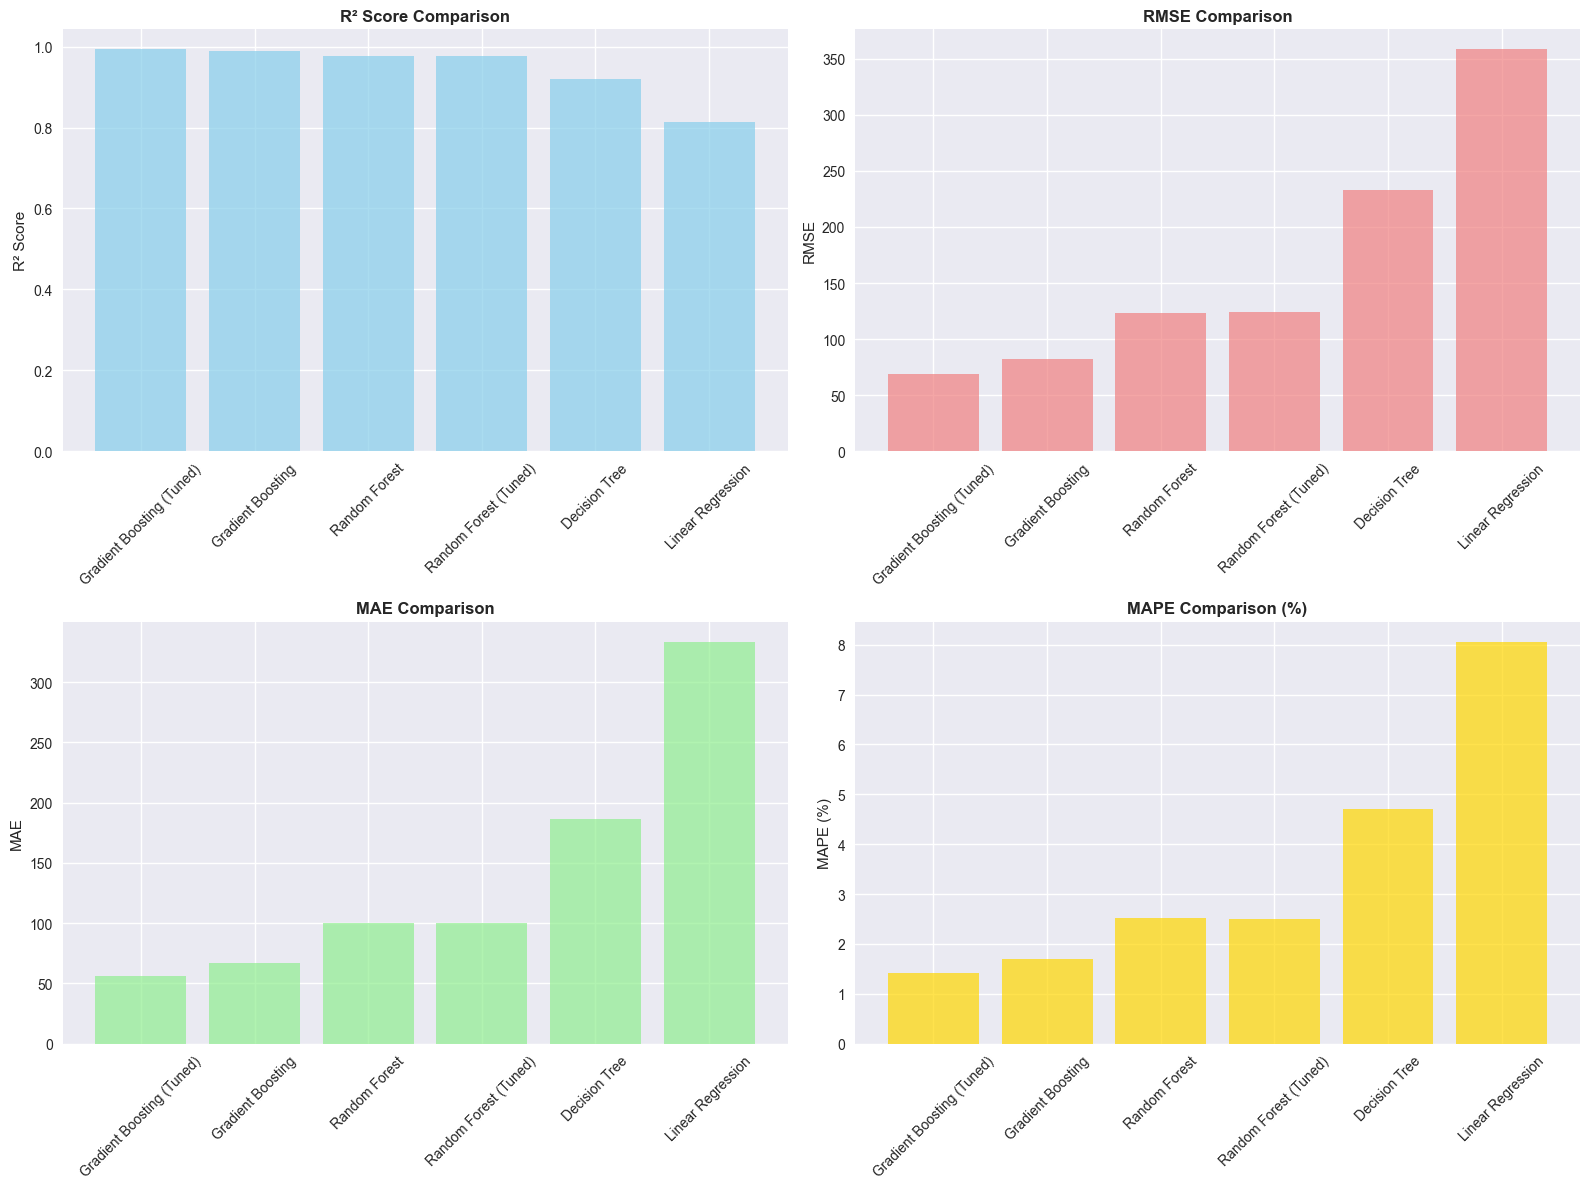

In [11]:
# Cell 12: Visualize model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score comparison
axes[0, 0].bar(results_df['Model'], results_df['R²'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('R² Score Comparison', fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[0, 1].bar(results_df['Model'], results_df['RMSE'], color='lightcoral', alpha=0.7)
axes[0, 1].set_title('RMSE Comparison', fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1, 0].bar(results_df['Model'], results_df['MAE'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('MAE Comparison', fontweight='bold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=45)

# MAPE comparison
axes[1, 1].bar(results_df['Model'], results_df['MAPE'], color='gold', alpha=0.7)
axes[1, 1].set_title('MAPE Comparison (%)', fontweight='bold')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Best Model: Gradient Boosting (Tuned)
Best Model R² Score: 0.9930


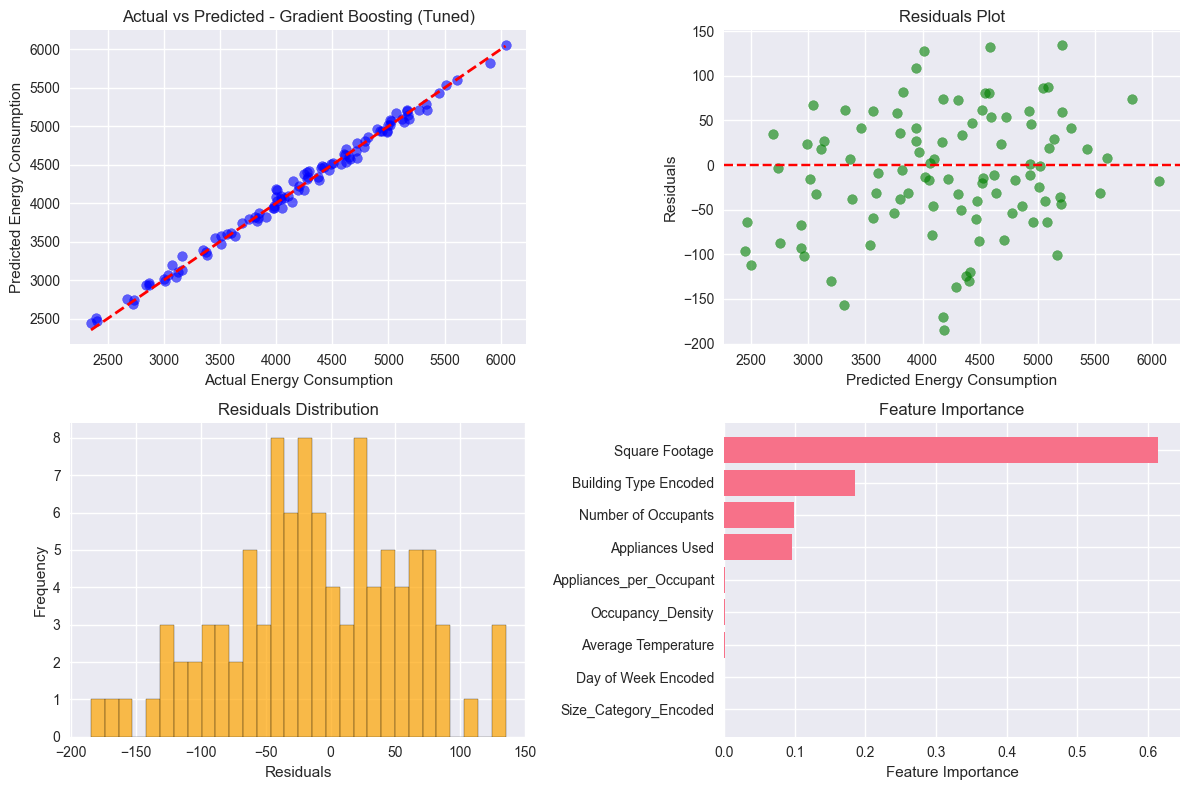

In [12]:
# Cell 13: Best model analysis and predictions visualization
# Get the best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_predictions = predictions_dict[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Model R² Score: {results_df.iloc[0]['R²']:.4f}")

# Actual vs Predicted plot
plt.figure(figsize=(12, 8))

# Scatter plot
plt.subplot(2, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title(f'Actual vs Predicted - {best_model_name}')

# Residuals plot
plt.subplot(2, 2, 2)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Energy Consumption')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# Residuals histogram
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

# Feature importance (if available)
plt.subplot(2, 2, 4)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance')
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available\nfor this model', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')

plt.tight_layout()
plt.show()


## Feature Importance Analysis

Let's analyze which features are most important for predicting energy consumption.


Feature Importance Ranking:
Square Footage: 0.6144
Building Type Encoded: 0.1854
Number of Occupants: 0.0995
Appliances Used: 0.0959
Appliances_per_Occupant: 0.0017
Occupancy_Density: 0.0013
Average Temperature: 0.0012
Day of Week Encoded: 0.0004
Size_Category_Encoded: 0.0002


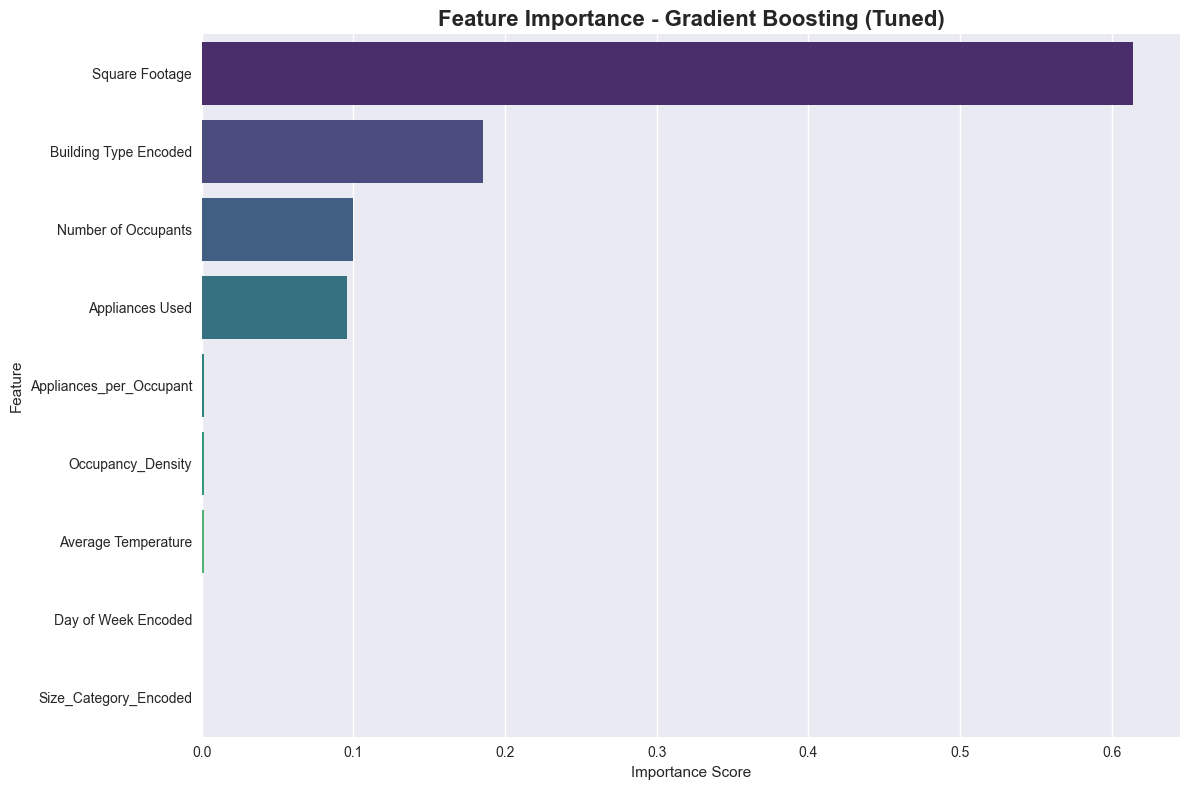


FEATURE IMPORTANCE INSIGHTS:
Top 3 most important features:
  1. Square Footage (0.6144)
  5. Building Type Encoded (0.1854)
  2. Number of Occupants (0.0995)

The top 3 features account for 89.9% of the model's decision-making process.


In [13]:
# Cell 14: Detailed feature importance analysis
if hasattr(best_model, 'feature_importances_'):
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Feature Importance Ranking:")
    print("="*40)
    for idx, row in feature_importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Feature importance insights
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE INSIGHTS:")
    print("="*50)
    
    top_3_features = feature_importance_df.head(3)
    print(f"Top 3 most important features:")
    for idx, row in top_3_features.iterrows():
        print(f"  {idx+1}. {row['Feature']} ({row['Importance']:.4f})")
    
    print(f"\nThe top 3 features account for {top_3_features['Importance'].sum():.1%} of the model's decision-making process.")


## Business Insights and Recommendations

Based on our analysis, let's extract key insights for energy management and efficiency.


In [14]:
# Cell 15: Business insights and data analysis
print("="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# Energy consumption by building type
building_stats = train_clean.groupby('Building Type')['Energy Consumption'].agg(['mean', 'std', 'min', 'max'])
print("\n1. ENERGY CONSUMPTION BY BUILDING TYPE:")
print(building_stats.round(2))

# Calculate efficiency metrics
train_clean['Energy_per_SqFt'] = train_clean['Energy Consumption'] / train_clean['Square Footage']
train_clean['Energy_per_Occupant'] = train_clean['Energy Consumption'] / (train_clean['Number of Occupants'] + 1)

efficiency_by_type = train_clean.groupby('Building Type')[['Energy_per_SqFt', 'Energy_per_Occupant']].mean()
print("\n2. ENERGY EFFICIENCY METRICS:")
print(efficiency_by_type.round(3))

# Temperature impact analysis
temp_bins = pd.cut(train_clean['Average Temperature'], bins=3, labels=['Low', 'Medium', 'High'])
temp_impact = train_clean.groupby(temp_bins)['Energy Consumption'].mean()
print("\n3. TEMPERATURE IMPACT ON ENERGY CONSUMPTION:")
print(temp_impact.round(2))

# Weekend vs Weekday analysis
day_impact = train_clean.groupby('Day of Week')['Energy Consumption'].agg(['mean', 'count'])
print("\n4. WEEKDAY VS WEEKEND ENERGY CONSUMPTION:")
print(day_impact.round(2))

# Appliance efficiency analysis
train_clean['Energy_per_Appliance'] = train_clean['Energy Consumption'] / (train_clean['Appliances Used'] + 1)
appliance_efficiency = train_clean.groupby('Building Type')['Energy_per_Appliance'].mean()
print("\n5. ENERGY CONSUMPTION PER APPLIANCE BY BUILDING TYPE:")
print(appliance_efficiency.round(2))


BUSINESS INSIGHTS AND RECOMMENDATIONS

1. ENERGY CONSUMPTION BY BUILDING TYPE:
                  mean     std      min      max
Building Type                                   
Commercial     4130.02  809.84  2241.96  5980.98
Industrial     4735.14  829.41  2724.82  6530.60
Residential    3681.63  847.62  1683.95  5746.40

2. ENERGY EFFICIENCY METRICS:
               Energy_per_SqFt  Energy_per_Occupant
Building Type                                      
Commercial               0.319              178.361
Industrial               0.359              205.251
Residential              0.256              145.199

3. TEMPERATURE IMPACT ON ENERGY CONSUMPTION:
Average Temperature
Low       4267.53
Medium    4067.69
High      4168.31
Name: Energy Consumption, dtype: float64

4. WEEKDAY VS WEEKEND ENERGY CONSUMPTION:
                mean  count
Day of Week                
Weekday      4170.29    507
Weekend      4162.10    493

5. ENERGY CONSUMPTION PER APPLIANCE BY BUILDING TYPE:
Building Type


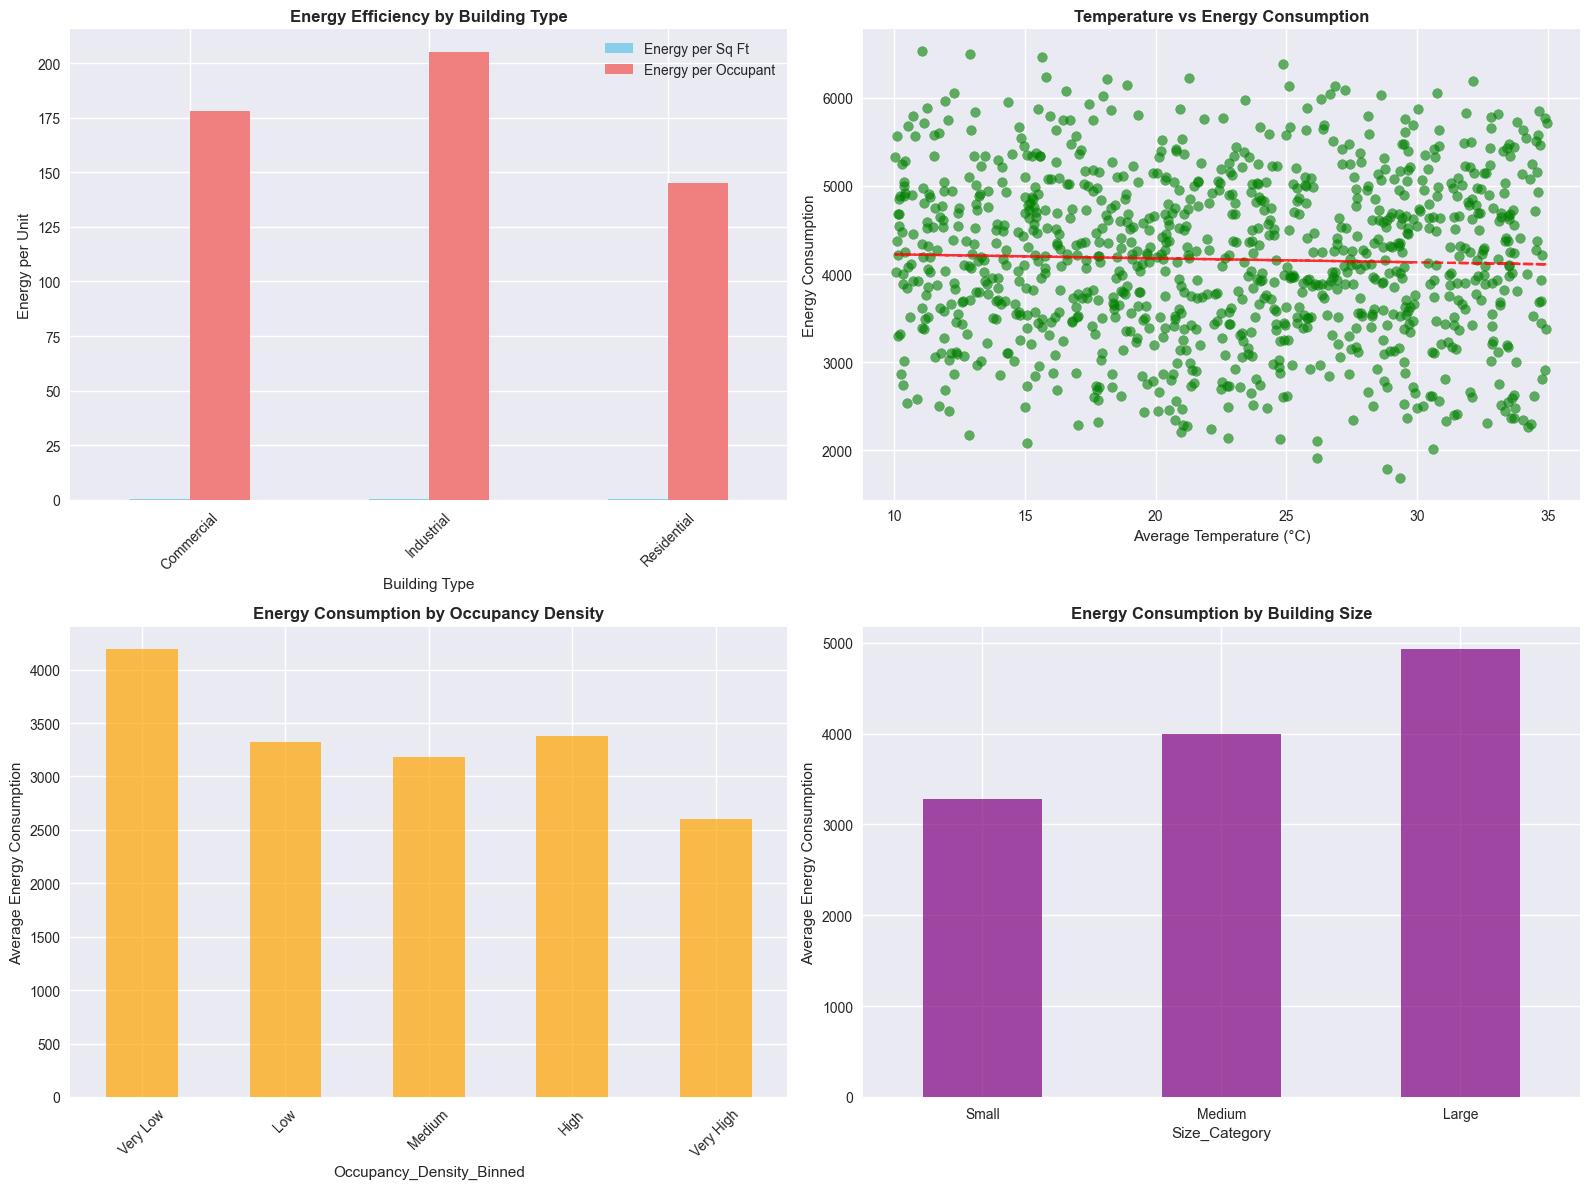

In [17]:
# Cell 16: Advanced insights visualization (ALTERNATIVE CORRECTED VERSION)
# Create a copy of train_clean with additional features for analysis
train_analysis = train_clean.copy()

# Add derived features for analysis
train_analysis['Occupancy_Density'] = train_analysis['Number of Occupants'] / train_analysis['Square Footage']
train_analysis['Size_Category'] = pd.cut(train_analysis['Square Footage'], 
                                         bins=[0, 15000, 30000, 50000], 
                                         labels=['Small', 'Medium', 'Large'])

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Energy efficiency by building type
efficiency_data = train_analysis.groupby('Building Type')[['Energy_per_SqFt', 'Energy_per_Occupant']].mean()
efficiency_data.plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightcoral'])
axes[0, 0].set_title('Energy Efficiency by Building Type', fontweight='bold')
axes[0, 0].set_ylabel('Energy per Unit')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend(['Energy per Sq Ft', 'Energy per Occupant'])

# Temperature vs Energy Consumption
axes[0, 1].scatter(train_analysis['Average Temperature'], train_analysis['Energy Consumption'], 
                   alpha=0.6, color='green')
axes[0, 1].set_xlabel('Average Temperature (°C)')
axes[0, 1].set_ylabel('Energy Consumption')
axes[0, 1].set_title('Temperature vs Energy Consumption', fontweight='bold')

# Add trend line
z = np.polyfit(train_analysis['Average Temperature'], train_analysis['Energy Consumption'], 1)
p = np.poly1d(z)
axes[0, 1].plot(train_analysis['Average Temperature'], p(train_analysis['Average Temperature']), "r--", alpha=0.8)

# Occupancy density impact
train_analysis['Occupancy_Density_Binned'] = pd.cut(train_analysis['Occupancy_Density'], 
                                                    bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
occupancy_impact = train_analysis.groupby('Occupancy_Density_Binned')['Energy Consumption'].mean()
occupancy_impact.plot(kind='bar', ax=axes[1, 0], color='orange', alpha=0.7)
axes[1, 0].set_title('Energy Consumption by Occupancy Density', fontweight='bold')
axes[1, 0].set_ylabel('Average Energy Consumption')
axes[1, 0].tick_params(axis='x', rotation=45)

# Building size impact
size_impact = train_analysis.groupby('Size_Category')['Energy Consumption'].mean()
size_impact.plot(kind='bar', ax=axes[1, 1], color='purple', alpha=0.7)
axes[1, 1].set_title('Energy Consumption by Building Size', fontweight='bold')
axes[1, 1].set_ylabel('Average Energy Consumption')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [18]:
# Cell 17: Create prediction function for deployment
def predict_energy_consumption(building_type, square_footage, num_occupants, 
                             appliances_used, avg_temperature, day_of_week):
    """
    Predict energy consumption for a new building
    
    Parameters:
    - building_type: 'Residential', 'Commercial', or 'Industrial'
    - square_footage: Building size in square feet
    - num_occupants: Number of people in the building
    - appliances_used: Number of appliances
    - avg_temperature: Average temperature in Celsius
    - day_of_week: 'Weekday' or 'Weekend'
    
    Returns:
    - Predicted energy consumption
    """
    
    # Create input DataFrame
    input_data = pd.DataFrame({
        'Building Type': [building_type],
        'Square Footage': [square_footage],
        'Number of Occupants': [num_occupants],
        'Appliances Used': [appliances_used],
        'Average Temperature': [avg_temperature],
        'Day of Week': [day_of_week]
    })
    
    # Process the input using the same preprocessing pipeline
    X_input, _, _, _ = prepare_features(input_data, le_building, le_day, scaler, fit_transform=False)
    
    # Make prediction
    prediction = best_model.predict(X_input)[0]
    
    return prediction

# Example predictions
print("EXAMPLE PREDICTIONS:")
print("="*40)

examples = [
    ('Residential', 2500, 4, 15, 22.0, 'Weekday'),
    ('Commercial', 10000, 50, 30, 20.0, 'Weekend'),
    ('Industrial', 25000, 100, 45, 18.0, 'Weekday')
]

for building_type, sq_ft, occupants, appliances, temp, day in examples:
    prediction = predict_energy_consumption(building_type, sq_ft, occupants, appliances, temp, day)
    print(f"{building_type} building ({sq_ft} sq ft, {occupants} occupants, {appliances} appliances, {temp}°C, {day}):")
    print(f"  Predicted Energy Consumption: {prediction:.2f}")
    print()


EXAMPLE PREDICTIONS:
Residential building (2500 sq ft, 4 occupants, 15 appliances, 22.0°C, Weekday):
  Predicted Energy Consumption: 1935.19

Commercial building (10000 sq ft, 50 occupants, 30 appliances, 20.0°C, Weekend):
  Predicted Energy Consumption: 3533.10

Industrial building (25000 sq ft, 100 occupants, 45 appliances, 18.0°C, Weekday):
  Predicted Energy Consumption: 5539.34



In [19]:
# Cell 18: Final model summary and export capabilities (CORRECTED)
print("="*60)
print("FINAL MODEL SUMMARY")
print("="*60)

# Get the best model information
best_model_row = results_df.iloc[0]
best_model_name = best_model_row['Model']
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Model Type: {type(best_model).__name__}")
print(f"R² Score: {best_model_row['R²']:.4f}")
print(f"RMSE: {best_model_row['RMSE']:.2f}")
print(f"MAE: {best_model_row['MAE']:.2f}")
print(f"MAPE: {best_model_row['MAPE']:.2f}%")

print(f"\nModel explains {best_model_row['R²']*100:.1f}% of energy consumption variance")
print(f"Average prediction error: ±{best_model_row['MAE']:.0f} energy units")

# Save model performance metrics
performance_summary = {
    'Best_Model': best_model_name,
    'R2_Score': best_model_row['R²'],
    'RMSE': best_model_row['RMSE'],
    'MAE': best_model_row['MAE'],
    'MAPE': best_model_row['MAPE'],
    'Features_Used': list(X_train.columns),
    'Training_Data_Size': len(train_clean),
    'Test_Data_Size': len(test_clean)
}

print("\n" + "="*60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)
print("The model is ready for deployment and can be used to predict")
print("energy consumption for new buildings based on their characteristics.")

# Optional: Display the performance summary dictionary
print(f"\nPerformance Summary:")
for key, value in performance_summary.items():
    if key != 'Features_Used':  # Skip features list for cleaner output
        print(f"  {key}: {value}")


FINAL MODEL SUMMARY
Best Model: Gradient Boosting (Tuned)
Model Type: GradientBoostingRegressor
R² Score: 0.9930
RMSE: 69.15
MAE: 55.88
MAPE: 1.43%

Model explains 99.3% of energy consumption variance
Average prediction error: ±56 energy units

PROJECT COMPLETED SUCCESSFULLY!
The model is ready for deployment and can be used to predict
energy consumption for new buildings based on their characteristics.

Performance Summary:
  Best_Model: Gradient Boosting (Tuned)
  R2_Score: 0.993031286917309
  RMSE: 69.15273359443636
  MAE: 55.87690724120441
  MAPE: 1.426366527887264
  Training_Data_Size: 1000
  Test_Data_Size: 100
